# Penggabungan Segmentasi Pixel-Level (Mask R-CNN) dan Superpixel-Level


In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt


ROOT_DIR = os.path.abspath("../../")


sys.path.append(ROOT_DIR) 
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples\\custom\\")) 
import custom

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs\\custom")

# Local path to trained weights file,sebelumnya 10
CUSTOM_MODEL_PATH = os.path.join(ROOT_DIR, "splitModels/mask_rcnn_custom_0080.h5")
# Download COCO trained weights

# Ketika pretrained model tidak di persiapkan. Akan otomatis mengunduh model yang sudah dilakukan pembelajaran menggunakan dataset COCO
if not os.path.exists(CUSTOM_MODEL_PATH):
    utils.download_trained_weights(CUSTOM_MODEL_PATH)
    
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/migellamp/opt/anacond

## Konfigurasi Model


In [2]:
class InferenceConfig(custom.CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Membentuk Model dan Class Name


In [3]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(CUSTOM_MODEL_PATH, by_name=True)

In [4]:
class_names = ['BG', 'bag', 'belt', 'boots', 'footwear', 'outer', 'dress', 'sunglasses', 'pants', 'top', 'shorts', 'skirt', 'headwear', 'scraf/tie']

## Fungsi Metode Segmentasi Pixel-Level (Bawaan Metode Mask R-CNN)


In [6]:
import json

class CustomDatasetForColorDetection(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the numbe of classes required to detect
        self.add_class("custom", 1, "bag")
        self.add_class("custom", 2, "belt")
        self.add_class("custom", 3, "boots")
        self.add_class("custom", 4, "footwear")
        self.add_class("custom", 5, "outer")
        self.add_class("custom", 6, "dress")
        self.add_class("custom", 7, "sunglasses")
        self.add_class("custom", 8, "pants")
        self.add_class("custom", 9, "top")
        self.add_class("custom", 10, "shorts")
        self.add_class("custom", 11, "skirt")
        self.add_class("custom", 12, "headwear")
        self.add_class("custom", 13, "scarf/tie")

        # Train or validation dataset?
        assert subset in ["train", "val","test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #labelling each class in the given image to a number

            custom = [s['region_attributes'] for s in a['regions'].values()]
            
            num_ids=[]
            #Add the classes according to the requirement
            for n in custom:
                try:
                    if n['label'] == 'bag':
                        num_ids.append(1)
                    elif n['label'] == 'belt':
                        num_ids.append(2)
                    elif n['label'] == 'boots':
                        num_ids.append(3)
                    elif n['label'] == 'footwear':
                        num_ids.append(4)
                    elif n['label'] == 'outer':
                        num_ids.append(5)
                    elif n['label'] == 'dress':
                        num_ids.append(6)
                    elif n['label'] == 'sunglasses':
                        num_ids.append(7)
                    elif n['label'] == 'pants':
                        num_ids.append(8)
                    elif n['label'] == 'top':
                        num_ids.append(9)
                    elif n['label'] == 'shorts':
                        num_ids.append(10)
                    elif n['label'] == 'skirt':
                        num_ids.append(11)
                    elif n['label'] == 'headwear':
                        num_ids.append(12)
                    elif n['label'] == 'scarf/tie':
                        num_ids.append(13)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "custom",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']	
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids#.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32), 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



## Deteksi dan Visualisasi Objek


Processing 1 images
image                    shape: (600, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


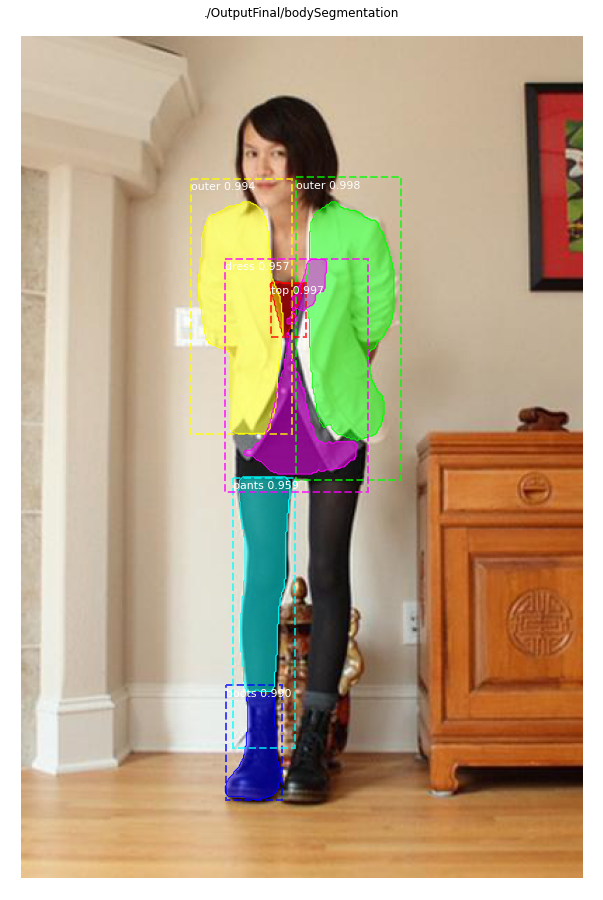

In [5]:
from mrcnn import visualize
image = skimage.io.imread(os.path.join('./datasetTesting/dataset/test/0000415.jpg'))
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'], title="./OutputFinal/bodySegmentation")


## Metode Segmentasi Superpixel-Level


### 1. Penguraian Mask Objek 

outer
top
outer
boots
pants
dress


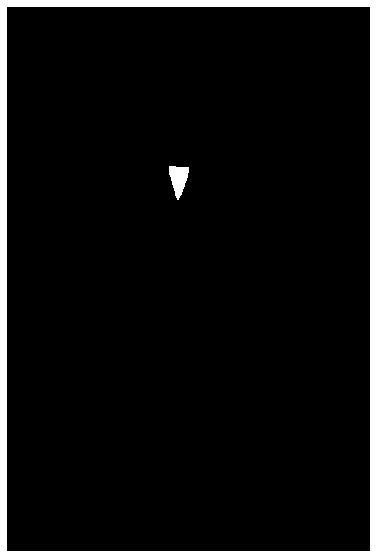

In [ ]:
plt.figure(figsize=(10, 10))
def make_segmentation_mask(image, mask):
    plt.axis('off')
    plt.imshow(mask,cmap='gray',interpolation='nearest')
mask = r['masks'][:,:,1]
make_segmentation_mask(image, mask)
for i in r['class_ids']:
    print(class_names[i])

# print(r['rois'].shape[0])

False


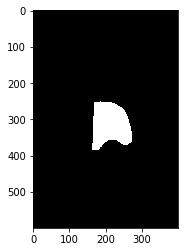

In [ ]:
from skimage import measure
import matplotlib.image as img

mask = r['masks'][:,:,2]
image = img.imread("./Source/valImage/0001312.jpg")
contours = measure.find_contours(mask,0.5)
# print(contours)
print(mask[125][232])
plt.imshow(mask,cmap='gray',interpolation='nearest')



### 2. Deteksi Objek Bentuk Tubuh Manusia



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

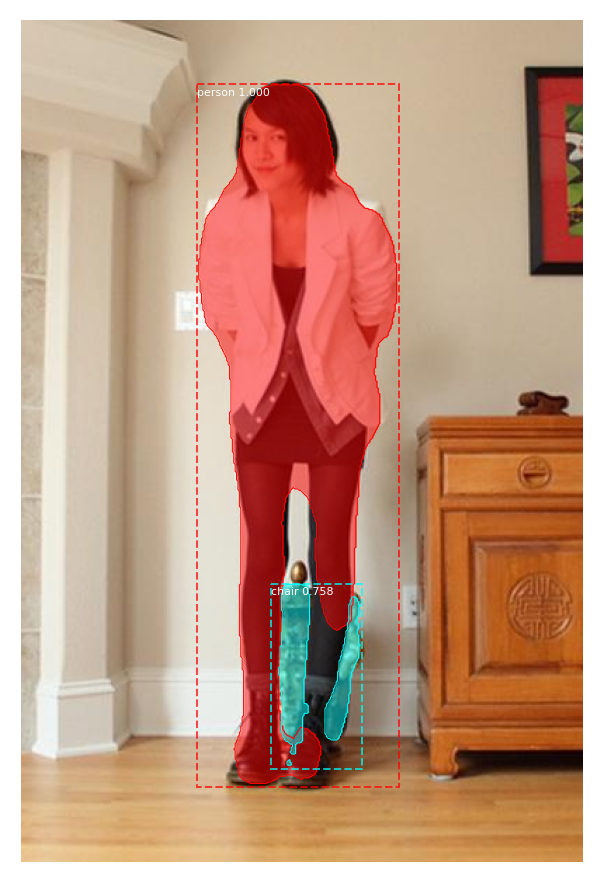

In [6]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import cv2
import colorsys
import argparse
# import imutils
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class SimpleConfig(Config):
    NAME = "coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 81

config1 = SimpleConfig()
config1.display()
model1 = modellib.MaskRCNN(mode="inference", config=config1, model_dir=os.getcwd())
model1.load_weights("../../splitModels/mask_rcnn_coco.h5", by_name=True)
class_names_orang = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush']

image2 = cv2.imread('./datasetTesting/dataset/test/0000415.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

result1 = model1.detect([image2], verbose=1)
r1 = result1[0]
visualize.display_instances(image2, r1['rois'], r1['masks'],r1['class_ids'], class_names_orang, r1['scores'])

### 3. Penguraian Objek Bentuk Tubuh Manusia

person
0


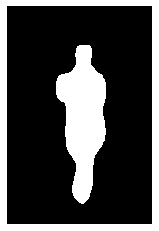

In [ ]:
ClassIndex = []
for i in r1['class_ids']:
    print(class_names_orang[i])
    ClassIndex.append(class_names_orang[i])
indexPerson = ClassIndex.index("person")
print(indexPerson)
# print(r1['rois'].shape[0])

mask2 = r1['masks'][:,:,indexPerson]
make_segmentation_mask(image2, mask2)
# get_coordinates(number)

### 4. Penggabungan Metode Segmentasi Pixel-Level dan Superpixel-Level


start processing ... 
[(<skimage.measure._regionprops.RegionProperties object at 0x7feaf2051e80>, 'no_class', '21', 'unpredicted', 0, 53.232142857142854, 183.66071428571428), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf2051eb8>, 'no_class', '18', 'unpredicted', 1, 55.812658227848104, 202.76962025316456), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf2059208>, 'no_class', '17', 'unpredicted', 2, 60.44583333333333, 171.45416666666668), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf20593c8>, 'no_class', '23', 'unpredicted', 3, 71.86819484240688, 208.51002865329514), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf2059470>, 'no_class', '17', 'unpredicted', 4, 74.2830626450116, 187.5290023201856), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf2059710>, 'no_class', '168', 'unpredicted', 5, 76.82448979591837, 165.80408163265307), (<skimage.measure._regionprops.RegionProperties object at 0x7feaf20598

/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:240: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:240: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:241: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/descartes/patch.py:46: ShapelyDepr

<Figure size 720x720 with 0 Axes>

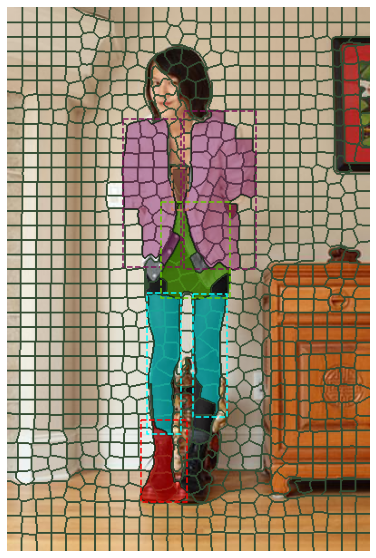

In [7]:
from descartes import PolygonPatch
import alphashape
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import matplotlib.image as img
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import cv2

def kasihwarna(rp, color1):
    for i in range(rp.shape[0]):
        image[rp[i][0]][rp[i][1]] = color1

def search(arr, N, x):
    for i in range(0, N):
        if (arr[i] == x):
            return i
    return -1

def searchArray(value, array):
    newArray = []
    for i in range(len(array)):
        if(array[i].class_name == value):
            newArray.push(array[i])
    return newArray

def changeFormat(rp):
    getintoarray = []
    for i in range(rp.shape[0]):
        getintoarray.append((rp[i][1], rp[i][0]))
    return getintoarray

class centroidAllPixel:
    def __init__(self, className, centroids):
        self.className = className
        self.centroids = centroids


image = img.imread('./datasetTesting/dataset/test/0000415.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# skin = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
imageSkin = cv2.imread('./datasetTesting/dataset/test/0000415.jpg')
skin = cv2.cvtColor(imageSkin, cv2.COLOR_BGR2YCR_CB)

plt.figure(figsize=(10, 10))
_, ax = plt.subplots(1, figsize=(10,10))

setsegmentnumber = 900
setsigma = 2
segments1 = slic(image, n_segments=setsegmentnumber, compactness=20, sigma=setsigma, convert2lab=True)

flag = 1
numberofTrue = 0
flag_text = 1

arrayOfClass = []
allColorArray = []
break_out_flag = False

allPixelDesc = []
allNotPredictedPixel = []
allClassName =[]

pixelNumber = 0
allPixels = []

saveCoordinates = []
shapeCoordinates = []
isDone = False

saveAllPixelone = []
saveAllPredictedMask = []*2

AllChangedPixel = []


color = dict(
    top=(210/255,126/255,89/255),
    footwear=(210/255,188/255,89/255),
    outer=(125/255,21/255,89/255),
    skirt=(89/255,144/255,210/255),
    dress=(102/255,204/255,0),
    pants=(0,255/255,255/255),
    belt=(255/255,0,255/255),
    headwear=(255/255,153/255,153/255), 
    boots=(255/255,0,0),
    bag=(0,1,0),
    shorts=(0,0,1),
    sunglasses=(0.3,1,0.8),
    scarf=(0.4,0.5,1),
    no_class=(0,0,0),
)
ClassIndex = []

for i in r1['class_ids']:
    ClassIndex.append(class_names_orang[i])

for region in regionprops(segments1):
    minr, minc, maxr, maxc = region.bbox
    cx, cy = region.centroid
    mask_num = len(r['class_ids'])
    indexPerson = ClassIndex.index("person")
    maskBody = r1['masks'][:,:,indexPerson]
    # if (maskBody[int(cx)][int(cy)] == True):
    for number in range(mask_num):
        maskClothing = r['masks'][:,:,number]
        if(maskClothing[int(cx)][int(cy)] == True
            or maskClothing[int(cx-1)][int(cy)] == True
                or maskClothing[int(cx+1)][int(cy)] == True
                    or maskClothing[int(cx)][int(cy-1)] == True
                        or maskClothing[int(cx)][int(cy+1)] == True):
            each_classnames = class_names[r['class_ids'][number]]
            if(pixelNumber > 0):
                if(allPixelDesc[pixelNumber-1][0] == region):
                    continue
            status = "predicted"
            c1 = str(gray[int(cx),int(cy)])
            allPixelDesc.append((region, each_classnames, c1, status, pixelNumber,cx,cy))
            pixelNumber+=1
            numberofTrue+=1
    if(numberofTrue<1):
        if (maskBody[int(cx)][int(cy)] == True):
        # plt.text(cy,cx,pixelNumber ,color="yellow")
            status = "unpredicted"
            allPixelDesc.append((region, "no_class", str(gray[int(cx),int(cy)]),status, pixelNumber,cx,cy))
            pixelNumber+=1
    numberofTrue = 0
    flag+=1
    alpha = 0.5 

print("start processing ... ")

for i in r['class_ids']:
    allClassName.append(class_names[i])

print(allPixelDesc)

for i in range(len(allPixelDesc)):
    raw_coordinate = allPixelDesc[i][0].coords
    new_coordinate = changeFormat(np.array(raw_coordinate))
    cx, cy = allPixelDesc[i][0].centroid    
    lower = np.array([0, 133, 77], dtype = "uint8")
    upper = np.array([235, 173, 127], dtype = "uint8")
    skinArea = cv2.inRange(skin[int(cx)][int(cy)], lower,upper) 
    indexPerson = ClassIndex.index("person")
    maskBody = r1['masks'][:,:,indexPerson]   
    
    if(allPixelDesc[i][3] == "predicted"):
        if(len(saveAllPredictedMask) == 0):
            saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
            continue
        else:
            if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
            else:
                for j in range(len(saveAllPredictedMask)):
                    if(saveAllPredictedMask[j][0] == allPixelDesc[i][1]):
                        saveAllPredictedMask[j][1].extend(new_coordinate)
            continue

    if(allPixelDesc[i][3] == "unpredicted"):
        for j in range(len(allPixelDesc)):
            if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == allPixelDesc[i-1] and allPixelDesc[j][1] == allPixelDesc[i+1]):
                allPixelDesc[i] = (allPixelDesc[i][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                if(allPixelDesc[i][4] not in AllChangedPixel):
                    AllChangedPixel.append(allPixelDesc[i][4])
                if(allPixelDesc[j][1] not in np.array(saveAllPredictedMask,dtype=object)):
                    saveAllPredictedMask.append((allPixelDesc[j][1], new_coordinate))
                else:
                    for k in range(len(saveAllPredictedMask)):
                        if(saveAllPredictedMask[k][0] == allPixelDesc[j][1]):
                            saveAllPredictedMask[k][1].extend(new_coordinate)   
            if(j < len(allPixelDesc)):
                if(len(allPixelDesc)!= i+1):
                    if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == allPixelDesc[i+1][1]):
                        allPixelDesc[i] = (allPixelDesc[i+1][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                        if(allPixelDesc[i][4] not in AllChangedPixel):
                            AllChangedPixel.append(allPixelDesc[i][4])
                        if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                            saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
                        else:
                            for k in range(len(saveAllPredictedMask)):
                                if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
                                    saveAllPredictedMask[k][1].extend(new_coordinate)
            if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == allPixelDesc[i-1][1]):
                allPixelDesc[i] = (allPixelDesc[i-1][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                if(allPixelDesc[i][4] not in AllChangedPixel):
                    AllChangedPixel.append(allPixelDesc[i][4])
                if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                    saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
                else:
                    for k in range(len(saveAllPredictedMask)):
                        if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
                            saveAllPredictedMask[k][1].extend(new_coordinate)

for i in range(len(AllChangedPixel)):
    if(i<len(AllChangedPixel)):
        if(len(AllChangedPixel)!= i+1):
            print("range " + str(AllChangedPixel[i]) + "-" + str(AllChangedPixel[i+1]))
            for j in range(len(allPixelDesc)):
                if(allPixelDesc[j][3] == "unpredicted"):
                    raw_coordinate = allPixelDesc[j][0].coords
                    new_coordinate = changeFormat(np.array(raw_coordinate))
                    cx = allPixelDesc[j][5]
                    cy = allPixelDesc[j][6]
                    lower = np.array([0, 133, 77], dtype = "uint8")
                    upper = np.array([235, 173, 127], dtype = "uint8")
                    skinArea = cv2.inRange(skin[int(cx)][int(cy)], lower,upper)
                    indexPerson = ClassIndex.index("person")
                    maskBody = r1['masks'][:,:,indexPerson]
                    if(int(allPixelDesc[j][4])>int(AllChangedPixel[i]) and int(allPixelDesc[j][4]) < int(AllChangedPixel[i+1])
                    and allPixelDesc[AllChangedPixel[i]][1] == allPixelDesc[AllChangedPixel[i+1]][1] and skinArea[1]==0):
                        if(maskBody[int(cx)][int(cy)] == True):
                            if(allPixelDesc[AllChangedPixel[i]][1] not in np.array(saveAllPredictedMask,dtype=object)):
                                saveAllPredictedMask.append((allPixelDesc[AllChangedPixel[i]][1], new_coordinate))
                            else:
                                for k in range(len(saveAllPredictedMask)):
                                    if(saveAllPredictedMask[k][0] == allPixelDesc[AllChangedPixel[i]][1]):
                                        saveAllPredictedMask[k][1].extend(new_coordinate)   
                    #! Sebelumnya     
                    # if(int(allPixelDesc[j][4])>int(AllChangedPixel[i]) and int(allPixelDesc[j][4]) < int(AllChangedPixel[i+1])
                    #     and allPixelDesc[AllChangedPixel[i]][1] == allPixelDesc[AllChangedPixel[i+1]][1] and skinArea[1]==0):
                    #         if(allPixelDesc[AllChangedPixel[i]][1] not in np.array(saveAllPredictedMask,dtype=object)):
                    #             saveAllPredictedMask.append((allPixelDesc[AllChangedPixel[i]][1], new_coordinate))
                    #         else:
                    #             for k in range(len(saveAllPredictedMask)):
                    #                 if(saveAllPredictedMask[k][0] == allPixelDesc[AllChangedPixel[i]][1]):
                    #                     saveAllPredictedMask[k][1].extend(new_coordinate)   


for i in range(len(saveAllPredictedMask)):
    alpha_shape = alphashape.alphashape(saveAllPredictedMask[i][1], 1)
    if(alpha_shape.type == "Polygon"):
        xx,yy = alpha_shape.exterior.coords.xy
        xs = [min(xx),max(xx),max(xx),min(xx),min(xx)]
        ys = [min(yy),min(yy),max(yy),max(yy),min(yy)]
        ax.plot(xs, ys, color=color[saveAllPredictedMask[i][0]],linestyle='dashed')
    if(alpha_shape.type == "MultiPolygon"):
        for j in range(len(list(alpha_shape))):
            xx, yy = alpha_shape[j].exterior.coords.xy
            xs = [min(xx),max(xx),max(xx),min(xx),min(xx)]
            ys = [min(yy),min(yy),max(yy),max(yy),min(yy)]
            ax.plot(xs, ys, color=color[saveAllPredictedMask[i][0]], linestyle='dashed')
    ax.add_patch(PolygonPatch(alpha_shape, alpha=0.5,color=color[saveAllPredictedMask[i][0]],ec='black'))


plt.imshow(image.astype(np.uint8))
plt.imshow(mark_boundaries((image).astype(np.uint8), segments1, color=(0.2,0.3,0.2), mode="thick"))
plt.axis('off') 
plt.axis("image") 
plt.savefig("new", bbox_inches='tight') 

### Percobaan Pengambilan Koordinat Piksel - AlphaShapes

dress


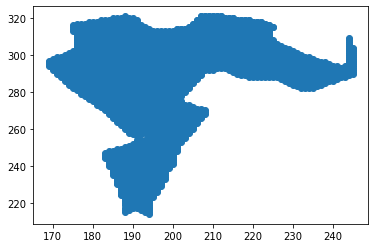

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import alphashape

print(saveAllPredictedMask[2][0])
num = saveAllPredictedMask[2][1]
fig, ax = plt.subplots()
ax.scatter(*zip(*num))
# alphaaaa = alphashape.alphashape(num, 0.1)
# print(alphaaaa)
# ax.add_patch(PolygonPatch(alphaaaa, alpha=0.9))
plt.show()

### Pengecekan Deteksi Warna Kulit

In [ ]:
dataset = CustomDataset()
dataset.load_custom("datasetTesting/dataset", "test")
dataset.prepare()


min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)  

print(len(dataset.image_ids))
for image_id in dataset.image_ids:
    plt.figure(figsize=(10, 10))
    _, ax = plt.subplots(1, figsize=(8,8))
    imageName = dataset.image_reference(image_id)
    image = cv2.imread(imageName)
    imageYCrCb = cv2.cvtColor(image,cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)

    skinYCrCb = cv2.bitwise_and(image, image, mask = skinRegionYCrCb)
    screen = cv2.cvtColor(skinYCrCb, cv2.COLOR_RGB2BGR)
    plt.imshow(screen)

# Evaluasi Acc dan IoU pada Semua Model

In [ ]:
newMaskEvaluation = []*2
superPixelmask = np.zeros([600, 400, len(saveAllPredictedMask)],
                    dtype=np.uint8)
for i in range(len(saveAllPredictedMask)):
    getOuterOnly = alphashape.alphashape(saveAllPredictedMask[i][1], 0.8)
    if(getOuterOnly.type == "Polygon"):
        xx,yy = getOuterOnly.exterior.coords.xy
        rr, cc = skimage.draw.polygon(yy, xx)
        superPixelmask[rr, cc, i] = 1
    if(getOuterOnly.type == "MultiPolygon"):
        for j in range(len(list(getOuterOnly))):
            xx, yy = getOuterOnly[j].exterior.coords.xy
            rr, cc = skimage.draw.polygon(yy, xx)
            superPixelmask[rr, cc, i] = 1

# print(superPixelmask)


/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  # This is added back by InteractiveShellApp.init_path()
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  # This is added back by InteractiveShellApp.init_path()
/Users/migellamp/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part 

In [ ]:
from skimage import io
def segm_size(segm):
    try:
        height = segm.shape[0]
        width = segm.shape[1]
    except IndexError:
        raise

    return height, width

def merged_mask(masks):
    n= masks.shape[2]
    
    if n!=0:        
        merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
        for i in range(n):
            merged_mask+=masks[...,i]
        merged_mask=np.asarray(merged_mask,dtype=np.uint8)   
        return merged_mask
    return masks[:,:,0]

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)

def compute_acc(mask1, mask2):
    predict_mask = merged_mask(mask1)
    gt_mask = merged_mask(mask2)
    check_size(predict_mask, gt_mask)

    N_p = np.sum(gt_mask)
    N_n = np.sum(np.logical_not(gt_mask))

    TP = np.sum(np.logical_and(predict_mask, gt_mask))
    TN = np.sum(np.logical_and(np.logical_not(predict_mask), np.logical_not(gt_mask)))

    accuracy_ = ((TP + TN) / (N_p + N_n)) * 100

    return accuracy_

def compute_iou(predict_mask, gt_mask):
    if predict_mask.shape[2]==0:
        return 0
    mask1 = merged_mask(predict_mask)
    mask2 = merged_mask(gt_mask)

    # intersection = np.sum((mask1 + mask2) > 1)
    # union = np.sum((mask1 + mask2) > 0)
    # iou_score = intersection / float(union)

    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    #print("Iou 2 : ",iou_score)
    return iou_score * 100

dataset = CustomDataset()
dataset.load_custom("datasetTesting/dataset/", "test")
dataset.prepare()

IoU_list = []
acc_list = []

# image = skimage.io.imread(os.path.join("Source/valImage", "0001312.jpg"))
# mask, class_ids = dataset.load_mask(10)
mask, class_ids = dataset.load_mask(0)

# visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
if(superPixelmask.size != 0):
    IoU = compute_iou(mask, r['masks'])
    acc= compute_acc(mask, r['masks'])

    IoUSP = compute_iou(mask, superPixelmask)
    accSP= compute_acc(mask, superPixelmask)
else:
    IoU = 0
    acc= 0

    IoUSP = 0
    accSP= 0

# IoUSPRcnn = compute_iou(r['masks'], superPixelmask)
# accSPRcnn = compute_acc(r['masks'], superPixelmask)

print('Hasil IoU Mask R-CNN:',IoU)
print('Hasil Acc Mask R-CNN:',acc)

print('Hasil IoU Superpixel:',IoUSP)
print('Hasil Acc Superpixel:',accSP)

# print('Hasil IoU Superpixel & Mask R-CNN:',IoUSPRcnn)
# print('Hasil Acc Superpixel & Mask R-CNN:',accSPRcnn)


Hasil IoU Mask R-CNN: 66.82681176198194
Hasil Acc Mask R-CNN: 95.0388409268593
Hasil IoU Superpixel: 66.4972154790804
Hasil Acc Superpixel: 95.11168703463736


# Progress Pengerjaan Program

### Gabungan Metode Segmentasi Pixel-Level dan Superpixel-Level (Versi Sebelumnya)


start processing ... 
[(<skimage.measure._regionprops.RegionProperties object at 0x7fb8e0d1ada0>, 'headwear', '110', 'predicted', 0), (<skimage.measure._regionprops.RegionProperties object at 0x7fb8e0d1a0b8>, 'headwear', '152', 'predicted', 1), (<skimage.measure._regionprops.RegionProperties object at 0x7fb8e0d1a518>, 'no_class', '172', 'unpredicted', 2), (<skimage.measure._regionprops.RegionProperties object at 0x7fb95c8e8828>, 'no_class', '189', 'unpredicted', 3), (<skimage.measure._regionprops.RegionProperties object at 0x7fb980bb8630>, 'no_class', '160', 'unpredicted', 4), (<skimage.measure._regionprops.RegionProperties object at 0x7fb980bb85c0>, 'no_class', '176', 'unpredicted', 5), (<skimage.measure._regionprops.RegionProperties object at 0x7fb95c8ff630>, 'dress', '180', 'predicted', 6), (<skimage.measure._regionprops.RegionProperties object at 0x7fb95a49ccc0>, 'no_class', '134', 'unpredicted', 7), (<skimage.measure._regionprops.RegionProperties object at 0x7fb9942db128>, 'dress'

<Figure size 720x720 with 0 Axes>

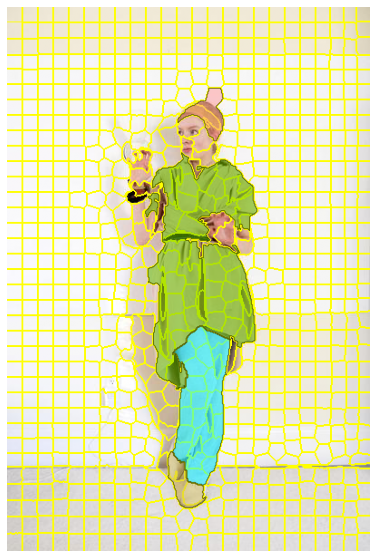

In [ ]:
from descartes import PolygonPatch
import alphashape
import numpy as np
from skimage.segmentation import slic
import matplotlib.pyplot as plt
import matplotlib.image as img
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import cv2

def kasihwarna(rp, color1):
    for i in range(rp.shape[0]):
        image[rp[i][0]][rp[i][1]] = color1

def search(arr, N, x):
    for i in range(0, N):
        if (arr[i] == x):
            return i
    return -1

def searchArray(value, array):
    newArray = []
    for i in range(len(array)):
        if(array[i].class_name == value):
            newArray.push(array[i])
    return newArray

def coloring(rp):
    getintoarray = []
    for i in range(rp.shape[0]):
        getintoarray.append((rp[i][1], rp[i][0]))
    return getintoarray

class centroidAllPixel:
    def __init__(self, className, centroids):
        self.className = className
        self.centroids = centroids


image = img.imread("./Source/valImage/0001312.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
_, ax = plt.subplots(1, figsize=(10,10))

setsegmentnumber = 800
setsigma = 1
segments1 = slic(image, n_segments=setsegmentnumber, compactness=10, sigma=setsigma, convert2lab=True)

flag = 1
numberofTrue = 0
flag_text = 1

arrayOfClass = []
allColorArray = []
break_out_flag = False

allPixelDesc = []
allNotPredictedPixel = []
allClassName =[]

pixelNumber = 0
allPixels = []

saveCoordinates = []
shapeCoordinates = []
isDone = False

saveAllPixelone = []
saveAllPredictedMask = []*2


color = dict(
    top=(210/255,126/255,89/255),
    footwear=(210/255,188/255,89/255),
    outer=(125/255,21/255,89/255),
    skirt=(89/255,144/255,210/255),
    dress=(102/255,204/255,0),
    pants=(0,255/255,255/255),
    belt=(255/255,0,255/255),
    headwear=(255/255,153/255,153/255), 
    boots=(255/255,0,0),
    bag=(0,1,0),
    no_class=(0,0,0),
)
ClassIndex = []

for i in r1['class_ids']:
    ClassIndex.append(class_names_orang[i])

for region in regionprops(segments1):
    minr, minc, maxr, maxc = region.bbox
    cx, cy = region.centroid
    point_1 = Feature(geometry=Point((cy,cx))) #tengah
    point_2 = Feature(geometry=Point((cy-1,cx))) #bawah
    point_3 = Feature(geometry=Point((cy+1,cx))) #atas
    point_4 = Feature(geometry=Point((cy,cx+1))) #kanan
    point_5 = Feature(geometry=Point((cy,cx-1)))# kiri
    mask_num = len(r['class_ids'])
    warna = [(210,126,89), 
        (210,188,89),
        (155,210,89),
        (89,210,117),
        (89,210,199),
        (89,144,210),
        (124,89,210),
        (205,89,210),
        (210,89,113)]
    polygon1 = Polygon(
        [
            get_coordinates_orang(0)
        ]
    )
    for i in range(len(ClassIndex)):
        if(ClassIndex[i] == "handbag"):
            polygonHandbag = Polygon(
                [
                    get_coordinates_orang(i)
                ]
            )
            if (boolean_point_in_polygon(point_1, polygonHandbag) == True):
                # plt.text(cy-2,cx,pixelNumber ,color="yellow")
                for number in range(mask_num):
                    polygon = Polygon(
                        [
                            get_coordinates(number)
                        ]
                    )
                    if(boolean_point_in_polygon(point_1, polygon) == True
                                or boolean_point_in_polygon(point_2, polygon) == True
                                    or boolean_point_in_polygon(point_3, polygon) == True
                                        or boolean_point_in_polygon(point_4, polygon) == True
                                            or boolean_point_in_polygon(point_5, polygon) == True):
                        each_classnames = str(get_classnames(number))
                        if(pixelNumber > 0):
                            if(allPixelDesc[pixelNumber-1][0] == region):
                                continue
                        status = "predicted"
                        allPixelDesc.append((region, each_classnames, str(gray[int(cx),int(cy)]),status, pixelNumber))
                        pixelNumber+=1
                        numberofTrue+=1
                if(numberofTrue<1):
                    if (boolean_point_in_polygon(point_1, polygon1) == True):
                        status = "unpredicted"
                        allPixelDesc.append((region, "no_class", str(gray[int(cx),int(cy)]),status, pixelNumber))
                        pixelNumber+=1
                numberofTrue = 0
                flag+=1
    
    if (boolean_point_in_polygon(point_1, polygon1) == True):
    # plt.text(cy,cx,pixelNumber ,color="yellow")
        for number in range(mask_num):
            polygon = Polygon(
                [
                    get_coordinates(number)
                ]
            )
            if(boolean_point_in_polygon(point_1, polygon) == True
                    or boolean_point_in_polygon(point_2, polygon) == True
                        or boolean_point_in_polygon(point_3, polygon) == True
                            or boolean_point_in_polygon(point_4, polygon) == True
                                or boolean_point_in_polygon(point_5, polygon) == True):
                each_classnames = str(get_classnames(number))
                if(pixelNumber > 0):
                    if(allPixelDesc[pixelNumber-1][0] == region):
                        continue
                status = "predicted"
                allPixelDesc.append((region, each_classnames, str(gray[int(cx),int(cy)]),status, pixelNumber))
                pixelNumber+=1
                numberofTrue+=1
        if(numberofTrue<1):
            if(boolean_point_in_polygon(point_1, polygon1) == True):
                status = "unpredicted"
                allPixelDesc.append((region, "no_class", str(gray[int(cx),int(cy)]),status, pixelNumber))
                pixelNumber+=1
        numberofTrue = 0
        flag+=1
        alpha = 0.5 

print("start processing ... ")

for i in r['class_ids']:
    allClassName.append(class_names[i])

print(allPixelDesc)

for i in range(len(allPixelDesc)):
    raw_coordinate = allPixelDesc[i][0].coords
    new_coordinate = coloring(np.array(raw_coordinate))
    if(allPixelDesc[i][3] == "predicted"):
        if(len(saveAllPredictedMask) == 0):
            saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
            continue
        else:
            if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
            else:
                for j in range(len(saveAllPredictedMask)):
                    if(saveAllPredictedMask[j][0] == allPixelDesc[i][1]):
                        saveAllPredictedMask[j][1].extend(new_coordinate)
            continue

    if(allPixelDesc[i][3] == "unpredicted"):
        for k in range(i,len(allPixelDesc)):
            if(k < len(allPixelDesc)):
                if(len(allPixelDesc)!= k+1):
                    if(allPixelDesc[k][1] == "no_class"):
                        currentItem = allPixelDesc[k+1][1]
                    if(allPixelDesc[k][1] != "no_class"):
                        break
            # else:
            #     print(k, len(allPixelDesc))
        for j in range(len(allPixelDesc)):
            if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == currentItem and allPixelDesc[i-1][3] == "predicted" and allPixelDesc[i+1][3] == 'predicted'):
                allPixelDesc[i] = (allPixelDesc[i][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                if(allPixelDesc[j][1] not in np.array(saveAllPredictedMask,dtype=object)):
                    saveAllPredictedMask.append((allPixelDesc[j][1], new_coordinate))
                else:
                    for k in range(len(saveAllPredictedMask)):
                        if(saveAllPredictedMask[k][0] == allPixelDesc[j][1]):
                            saveAllPredictedMask[k][1].extend(new_coordinate)   

    if(allPixelDesc[i][3] == "unpredicted"):
        for j in range(len(allPixelDesc)):
            if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == allPixelDesc[i-1][1]):
                allPixelDesc[i] = (allPixelDesc[i-1][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                    saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
                else:
                    for k in range(len(saveAllPredictedMask)):
                        if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
                            saveAllPredictedMask[k][1].extend(new_coordinate)

    if(allPixelDesc[i][3] == "unpredicted"):
        for j in range(len(allPixelDesc)):
            if(j < len(allPixelDesc)):
                if(len(allPixelDesc)!= i+1):
                    if(allPixelDesc[i][2] == allPixelDesc[j][2] and allPixelDesc[j][3] == "predicted" and allPixelDesc[j][1] == allPixelDesc[i+1][1]):
                        allPixelDesc[i] = (allPixelDesc[i+1][0], allPixelDesc[j][1], allPixelDesc[j][2], "predicted", allPixelDesc[i][4])
                        if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
                            saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
                        else:
                            for k in range(len(saveAllPredictedMask)):
                                if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
                                    saveAllPredictedMask[k][1].extend(new_coordinate)

    # if(allPixelDesc[i][3] == "unpredicted"):
    #     if(allPixelDesc[i][4] == 0):
    #         continue
    #     if(allPixelDesc[i-1][3] == 'predicted'):
    #         allPixelDesc[i] = (allPixelDesc[i][0], allPixelDesc[i-1][1], allPixelDesc[i][2], allPixelDesc[i-1][3],allPixelDesc[i][4])
    #         if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
    #             saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
    #         else:
    #             for k in range(len(saveAllPredictedMask)):
    #                 if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
    #                     saveAllPredictedMask[k][1].extend(new_coordinate)
    #     if(allPixelDesc[i+1][3] == 'predicted'):
    #         allPixelDesc[i] = (allPixelDesc[i][0], allPixelDesc[i+1][1], allPixelDesc[i][2], allPixelDesc[i+1][3],allPixelDesc[i][4])
    #         if(allPixelDesc[i][1] not in np.array(saveAllPredictedMask,dtype=object)):
    #             saveAllPredictedMask.append((allPixelDesc[i][1], new_coordinate))
    #         else:
    #             for k in range(len(saveAllPredictedMask)):
    #                 if(saveAllPredictedMask[k][0] == allPixelDesc[i][1]):
    #                     saveAllPredictedMask[k][1].extend(new_coordinate)


for i in range(len(saveAllPredictedMask)):
    print(saveAllPredictedMask[i][0])
for i in range(len(saveAllPredictedMask)):
        alpha_shape = alphashape.alphashape(saveAllPredictedMask[i][1], 1)
        ax.add_patch(PolygonPatch(alpha_shape, alpha=0.5,color=color[saveAllPredictedMask[i][0]],ec='black'))

plt.imshow(image.astype(np.uint8))
plt.imshow(mark_boundaries((image).astype(np.uint8), segments1))
# plt.imshow((image).astype(np.uint8),cmap=matplotlib.colors.ListedColormap(color))
# plt.savefig("./ProgressRunning2/Progress_"+ strftime("%Y-%m-%d %H%M%S") + "_segment-" + str(setsegmentnumber)+ "_sigma-" + str(setsigma) +".jpg")
plt.axis('off') 
plt.axis("image") 
plt.savefig("new", bbox_inches='tight') 
# 223 228

### Metode Segmentasi Superpixel with Neighbor Status Method Only


In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from PIL import Image
from time import gmtime, strftime
from PIL import Image
from PIL import ImageDraw

import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
import cv2

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

def kasihwarna(rp, color1):
    for i in range(rp.shape[0]):
        image[rp[i][0]][rp[i][1]] = color1

def search(arr, N, x):
    for i in range(0, N):
        if (arr[i] == x):
            return i
    return -1

def searchArray(value, array):
    newArray = []
    for i in range(len(array)):
        if(array[i].class_name == value):
            newArray.push(array[i])
    return newArray

class centroidAllPixel:
    def __init__(self, className, centroids):
        self.className = className
        self.centroids = centroids

image = img.imread('./Source/valImage/0001312.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
setsegmentnumber = 100
setsigma = 1
segments1 = slic(image, n_segments=setsegmentnumber, compactness=30, sigma=setsigma)
flag = 1
numberofTrue = 0
flag_text = 1

arrayOfClass = []
allColorArray = []
break_out_flag = False

allPredictedPixel = []
allNotPredictedPixel = []
allClassName =[]

pixelNumber = 0
allPixels = []


color = dict(
    top=(0.210,0.126,0.89),
    footwear=(210,188,89),
    outer=(155,210,89),
    skirt=(89,144,210),
    dress=(0.102,0.204,0),
    pants=(0,255,255),
    belt=(255,0,255),
    headwear=(255,153,153), 
    sunglasses=(132,43,112),
    bag=(123,13,49),
)

for region in regionprops(segments1):
    minr, minc, maxr, maxc = region.bbox
    cx, cy = region.centroid

    point_1 = Feature(geometry=Point((cy-5,cx-5)))
    mask_num = len(r['class_ids'])
    warna = [(210,126,89), 
        (210,188,89),
        (155,210,89),
        (89,210,117),
        (89,210,199),
        (89,144,210),
        (124,89,210),
        (205,89,210),
        (210,89,113)]
    polygon1 = Polygon(
        [
            get_coordinates_orang(0)
        ]
    )
    if (boolean_point_in_polygon(point_1, polygon1) == True):
        plt.text(cy,cx,pixelNumber ,color="black")
        for number in range(mask_num):
            polygon = Polygon(
                [
                    get_coordinates(number)
                ]
            )
            if(boolean_point_in_polygon(point_1, polygon) == True):
                # kasihwarna(region.coords, (warna[number]))
                status = "predicted"
                each_classnames = str(get_classnames(number))
                allPixels.append((pixelNumber, each_classnames, str(gray[int(cx),int(cy)]),status, region, (int(cx),int(cy))))
                pixelNumber+=1
                numberofTrue+=1
            #print("Pixel ke- " + str(flag) + " --> " + str(get_classnames(number)) + " --> " + str(boolean_point_in_polygon(point_1, polygon)))
        if(numberofTrue<1):
            if (boolean_point_in_polygon(point_1, polygon1) == True):
                status = "unpredicted"
                allNotPredictedPixel.append(region)
                allPixels.append((pixelNumber, "no class_name", str(gray[int(cx),int(cy)]), status, region,(int(cx),int(cy))))
                pixelNumber+=1            
        numberofTrue = 0
        flag+=1


# kasihwarna(trueArray[6].coords, (111,0,255))
# newx, newy = trueArray[6].centroid
# print(str(gray[int(newx), int(newy)]))
print("Before : ")
print(allPixels)
NewPixel = np.array(allPixels)

for i in r['class_ids']:
    allClassName.append(class_names[i])

#? start detection with neighbor status
for i in range(len(NewPixel)):
    if(NewPixel[i][3] == 'predicted'):
        kasihwarna(NewPixel[i][4].coords,color[str(NewPixel[i][1])])
    # elif(NewPixel[i][3] == 'unpredicted'):
    #     if(NewPixel[i-1][3] == 'predicted'):
    #         NewPixel[i][1] = NewPixel[i-1][1]
    #         NewPixel[i][3] = "predicted"
    #         kasihwarna(NewPixel[i][4].coords,color[str(NewPixel[i-1][1])])
        # if(NewPixel[i+1][3] == 'predicted' and NewPixel[i+2][3] == 'predicted'):
        #     NewPixel[i][1] = NewPixel[i+2][1]
        #     NewPixel[i][3] = "predicted"
        #     kasihwarna(NewPixel[i][4].coords,color[str(NewPixel[i+2][1])])
#? end

print("After : ")
print(NewPixel)


#? Manual Testing 
# kasihwarna(allNotPredictedPixel[1].coords,color[str(allColorArray[1][0])])
# newx, newy = allNotPredictedPixel[1].centroid
# print(int(newx),int(newy))
# print(int(gray[int(newx), int(newy)]))
#? End Manual Testing

#? Manual Testing for unpredicted pixel
# for i in range(len(allNotPredictedPixel)):
#         kasihwarna(allNotPredictedPixel[i].coords,color[str(allColorArray[0][0])])
#? end

# xyz = 1
# for i in trueArray[6]:
#     newx, newy = i
#     newx += newx
#     xyz += 1
# print(newx/xyz)


plt.imshow((image).astype(np.uint8),cmap=matplotlib.colors.ListedColormap(color))
plt.imshow(mark_boundaries((image).astype(np.uint8), segments1))
plt.savefig("./ProgressRunning2/Progress_"+ strftime("%Y-%m-%d %H%M%S") + "_segment-" + str(setsegmentnumber)+ "_sigma-" + str(setsigma) +".jpg") 

In [ ]:
import numpy

a = [(0,"top",(1,2),"predicted"),(1,"skirt",(2,3),"unpredicted"), (2,"footwear",(3,4),"predicted")]
S=numpy.array(a)

print(a)

if(S[1][1] == "skirt"):
    S[1][1] = "not skirt"

print(S)



### Implementasi Progress Superpixel (Versi Sebelumnya pada Pra-TA)


<Figure size 720x720 with 0 Axes>

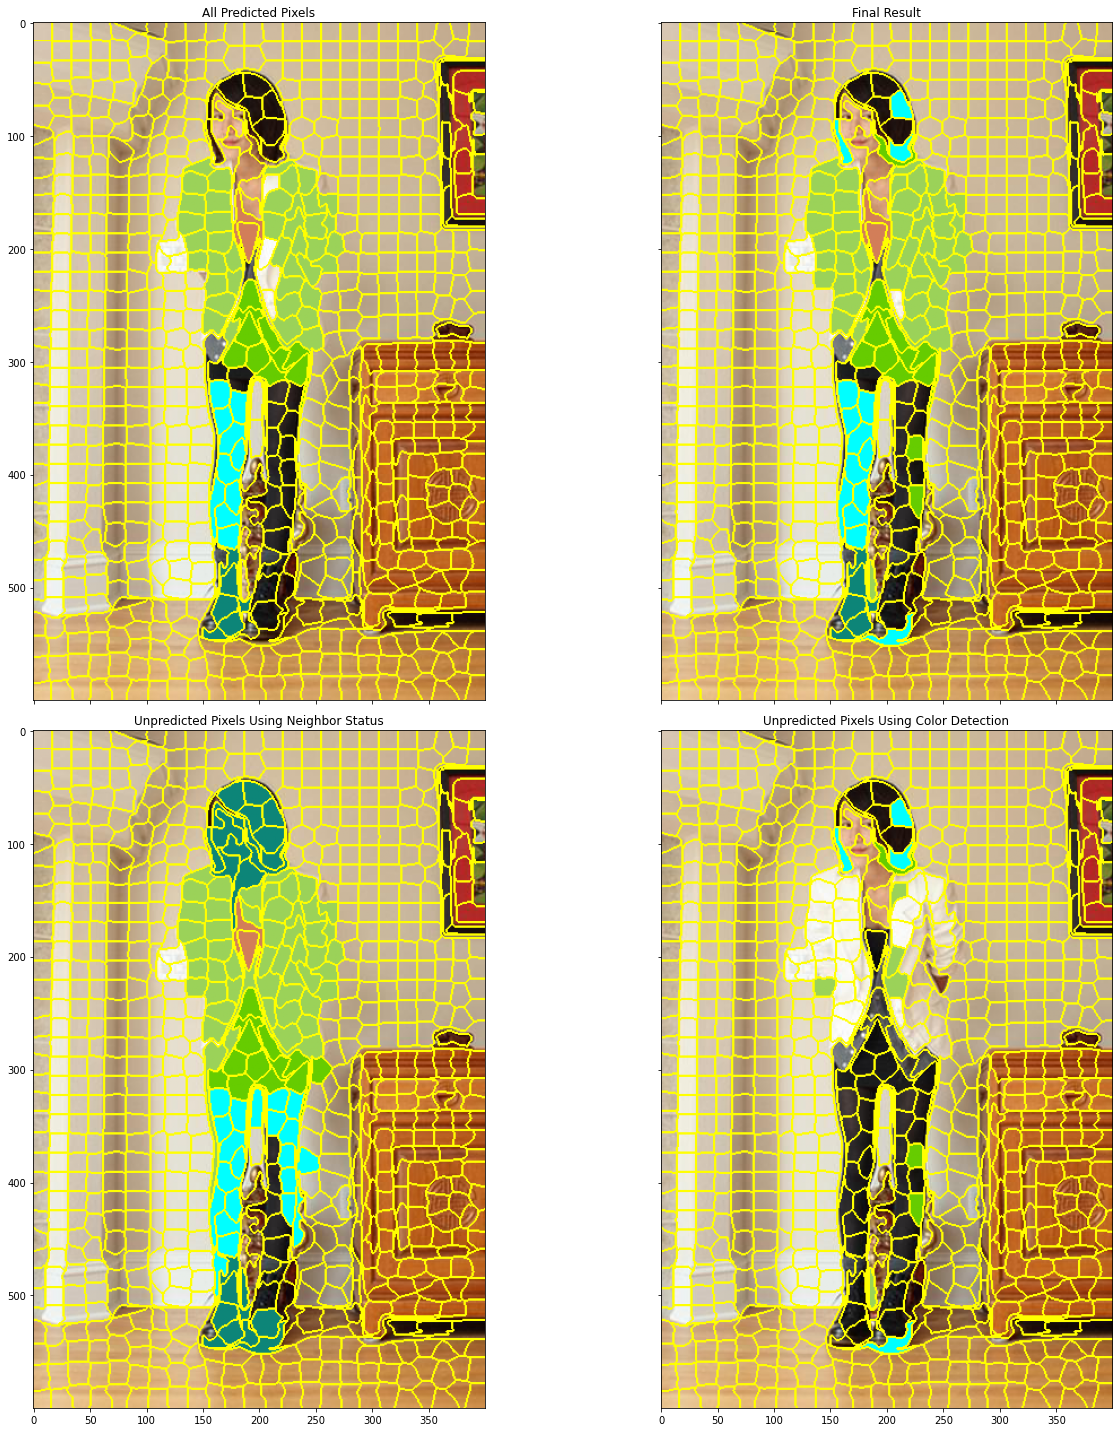

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from PIL import Image
from time import gmtime, strftime
from PIL import Image
from PIL import ImageDraw

import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
import cv2

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

def kasihwarna(imagesINPUT, rp, color1):
    for i in range(rp.shape[0]):
        imagesINPUT[rp[i][0]][rp[i][1]] = color1

def search(arr, N, x):
    for i in range(0, N):
        if (arr[i] == x):
            return i
    return -1

def searchArray(value, array):
    newArray = []
    for i in range(len(array)):
        if(array[i].class_name == value):
            newArray.push(array[i])
    return newArray

class centroidAllPixel:
    def __init__(self, className, centroids):
        self.className = className
        self.centroids = centroids

image = img.imread('datasetTesting/dataset/test/0000415.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

superpixelOnly = image.copy()
predictedImage = image.copy()
unpredictedImage = image.copy()
unpredictedNeighbor = image.copy()

plt.figure(figsize=(10, 10))
setsegmentnumber = 800
setsigma = 2
segments1 = slic(image, n_segments=setsegmentnumber, compactness=10, sigma=setsigma)
flag = 1
numberofTrue = 0
flag_text = 1

arrayOfClass = []
allColorArray = []
break_out_flag = False

allPredictedPixel = []
allNotPredictedPixel = []
allClassName = []

allPixelData = []
pixelNumber = 0


color = dict(
    top=(210,126,89),
    footwear=(210,188,89),
    outer=(155,210,89),
    skirt=(89,144,210),
    dress=(102,204,0),
    pants=(0,255,255),
    belt=(255,0,255),
    headwear=(255,153,153), 
    sunglasses=(132,43,112),
    bag=(123,13,49),
    boots=(13,133,120),
)

for region in regionprops(segments1):
    minr, minc, maxr, maxc = region.bbox
    cx, cy = region.centroid

    point_1 = Feature(geometry=Point((cy-5,cx-5)))
    mask_num = len(r['class_ids'])
    polygon1 = Polygon(
        [
            get_coordinates_orang(0)
        ]
    )
    if (boolean_point_in_polygon(point_1, polygon1) == True):
        for number in range(mask_num):
            polygon = Polygon(
                [
                    get_coordinates(number)
                ]
            )
            if(boolean_point_in_polygon(point_1, polygon) == True):
                each_classnames = str(get_classnames(number))
                allPredictedPixel.append(region)
                # Neighbor Condition
                status = "predicted"
                allPixelData.append((pixelNumber, each_classnames, str(gray[int(cx),int(cy)]), status, region))
                pixelNumber+=1
                # End Neighbor Condition
                allColorArray.append((each_classnames,str(gray[int(cx),int(cy)])))

                numberofTrue+=1
        if(numberofTrue<1):
            if (boolean_point_in_polygon(point_1, polygon1) == True):
                allNotPredictedPixel.append(region)
                # Neighbor Condition
                status = "unpredicted"
                allPixelData.append((pixelNumber, "no class_name", str(gray[int(cx),int(cy)]), status, region))
                pixelNumber+=1
                # End Neighbor Condition
        numberofTrue = 0
        flag+=1

for i in r['class_ids']:
    allClassName.append(class_names[i])

fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)

for i in range(len(allPredictedPixel)):
    for j in range(len(allColorArray)):
        for k in range(len(allClassName)):
            if (allColorArray[j][0] == allClassName[k]):
                kasihwarna(predictedImage, allPredictedPixel[j].coords,color[allClassName[k]])
                kasihwarna(image, allPredictedPixel[j].coords,color[allClassName[k]])

for i in range(len(allNotPredictedPixel)):
    newx, newy = allNotPredictedPixel[i].centroid
    for j in range(len(allColorArray)):
        if(int(gray[int(newx), int(newy)]) == int(allColorArray[j][1])):
        # if(int(gray[int(newx), int(newy)]) == int(allColorArray[j][1])):
            # print(newx,newy)
            kasihwarna(unpredictedImage,allNotPredictedPixel[i].coords,color[str(allColorArray[j][0])])
            kasihwarna(image,allNotPredictedPixel[i].coords,color[str(allColorArray[j][0])])

NewPixelData = np.array(allPixelData)

#? start detection with neighbor status
for i in range(len(NewPixelData)):
    if(NewPixelData[i][3] == 'predicted'):
        kasihwarna(unpredictedNeighbor, NewPixelData[i][4].coords,color[str(NewPixelData[i][1])])
    elif(NewPixelData[i][3] == 'unpredicted'):
        if(NewPixelData[i-1][3] == 'predicted'):
            NewPixelData[i][1] = NewPixelData[i-1][1]
            NewPixelData[i][3] = "predicted"
            kasihwarna(unpredictedNeighbor, NewPixelData[i][4].coords,color[str(NewPixelData[i-1][1])])
        # if(NewPixelData[i+1][3] == 'predicted'):
        #     NewPixelData[i][1] = NewPixelData[i+1][1]
        #     NewPixelData[i][3] = "predicted"
        #     kasihwarna(unpredictedNeighbor, NewPixelData[i][4].coords,color[str(NewPixelData[i+1][1])])
#? end

ax[0, 0].imshow(mark_boundaries((predictedImage).astype(np.uint8), segments1))
ax[0, 0].set_title("All Predicted Pixels")
ax[0, 1].imshow(image)
ax[0, 1].imshow(mark_boundaries((image).astype(np.uint8), segments1))
ax[0, 1].set_title('Final Result')
ax[1, 0].imshow(predictedImage)
ax[1, 0].imshow(mark_boundaries((unpredictedNeighbor).astype(np.uint8), segments1))
ax[1, 0].set_title('Unpredicted Pixels Using Neighbor Status')
ax[1, 1].imshow(unpredictedImage)
ax[1, 1].imshow(mark_boundaries((unpredictedImage).astype(np.uint8), segments1))
ax[1, 1].set_title('Unpredicted Pixels Using Color Detection')


# for a in ax.ravel():
#     a.set_axis_off()

plt.tight_layout()
plt.show()

# print(newx/xyz)

# plt.imshow((image).astype(np.uint8),cmap=matplotlib.colors.ListedColormap(color))
# plt.imshow(mark_boundaries((image).astype(np.uint8), segments1))
plt.savefig("./ProgressRunning2/Progress_"+ strftime("%Y-%m-%d %H%M%S") + "_segment-" + str(setsegmentnumber)+ "_sigma-" + str(setsigma) +".jpg") 

Felzenszwalb number of segments: 44
SLIC number of segments: 826
Quickshift number of segments: 616


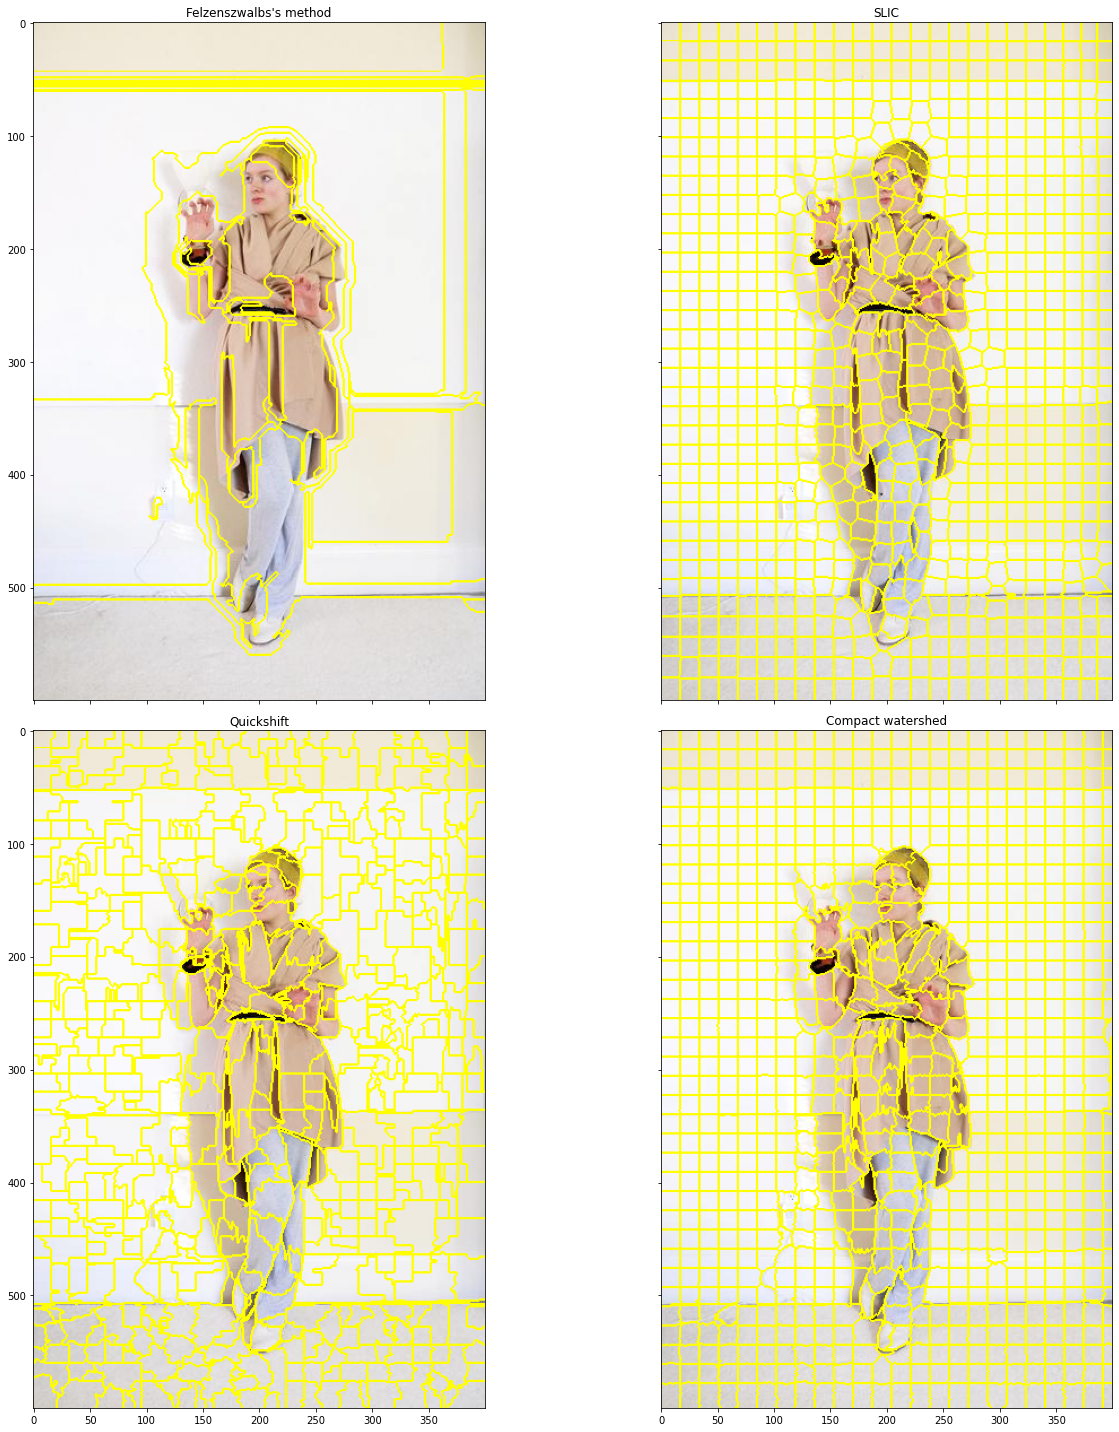

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
from turfpy.measurement import boolean_point_in_polygon
from geojson import Point, Polygon, Feature
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from PIL import Image
from time import gmtime, strftime
from PIL import Image
from PIL import ImageDraw

import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import regionprops
import cv2

img = img.imread('./Source/valImage/0001312.jpg')

segments_fz = felzenszwalb(img, scale=100, sigma=5, min_size=50)
segments_slic = slic(img, n_segments=800, compactness=20)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=800, compactness=0.002)


print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

# for a in ax.ravel():
#     a.set_axis_off()

plt.tight_layout()
plt.show()

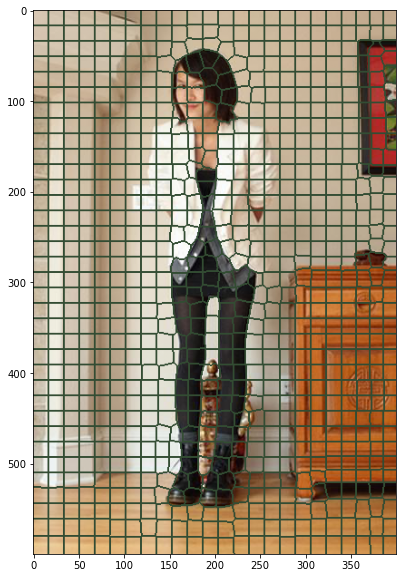

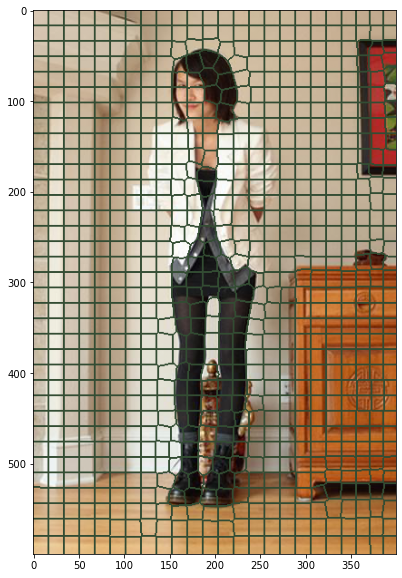

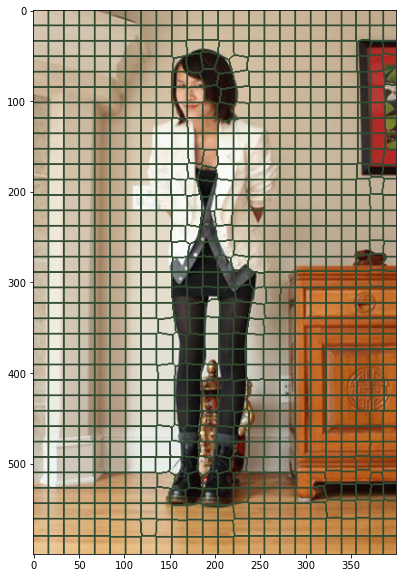

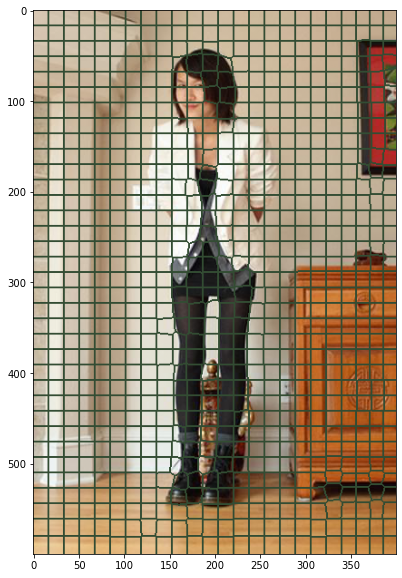

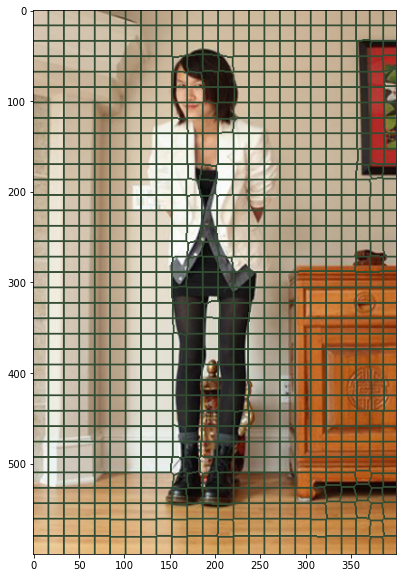

In [7]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse

image = img_as_float(io.imread('datasetTesting/dataset/test/0000415.jpg') )
# loop over the number of segments
# tambah --> deteksi tepi --> totalsegment
for numSegments in (1, 2, 3, 4, 5):
	segments = slic(image, n_segments = 800, sigma= numSegments, compactness=100)
	fig = plt.figure("Superpixels -- %d segments" % (numSegments), figsize=(10, 10))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(image, segments, color=(0.2,0.3,0.2), mode="thick"))
	# plt.axis("off")
plt.show()

In [ ]:
import cv2
import numpy as np
import pandas as pd
 
img = cv2.imread("Source/boy.jpg")

clicked = False
index = ["color", "color_name", "hex", "R", "G", "B"]
csv = pd.read_csv("Source/colors.csv", names=index, header=None)

def call_back_function (event, x,y,flags,param):
  if event == cv2.EVENT_LBUTTONDBLCLK:
        global b,g,r,xpos,ypos, clicked
        clicked = True
        xpos = x
        ypos = y
        b,g,r = img[y,x]
        b = int(b)
        g = int(g)
        r = int(r)

def get_Color_Name(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G-int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname
text = get_Color_Name(r,g,b)+'R='+str(r)+'G='+ str(g)+'B='+ str(b)
cv2.namedWindow("Color Detection Window")
cv2.setMouseCallback("Color Detection Window",call_back_function)

while(1):
  cv2.imshow("Color Detection Window",img)
  if (clicked):
    cv2.rectangle(img,(20,20), (750,60), (b,g,r), -1)
    text = get_Color_Name(r,g,b)+'R='+str(r)+'G='+ str(g)+'B='+ str(b)
    cv2.putText(img, text,(50,50),2,0.8, (255,255,255),2,cv2.LINE_AA)
    if(r+g+b>=600):
       cv2.putText(img, text,(50,50),2,0.8,(0,0,0),2,cv2.LINE_AA)
    clicked=False
    if cv2.waitKey(20) & 0xFF ==27:
      break
cv2.destroyAllWindows()




In [ ]:
import cv2
import numpy as np

# Load image, convert to grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('Source/boy.jpg')
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Obtain bounding rectangle and extract ROI
x,y,w,h = cv2.boundingRect(thresh)
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
ROI = original[y:y+h, x:x+w]

# Add alpha channel
b,g,r = cv2.split(ROI)
alpha = np.ones(b.shape, dtype=b.dtype) * 50
ROI = cv2.merge([b,g,r,alpha])

cv2.imshow('image', image)
cv2.imshow('ROI', ROI)
cv2.waitKey()